# Raisin Classfication

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_excel('Raisin_Dataset.xlsx')
X_raisin = df.drop('Class', axis=1).values
# Transform the class labels to -1 and 1
y_raisin = np.where(df['Class'].values == 'Kecimen', -1, 1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_raisin, y_raisin, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Some EDA

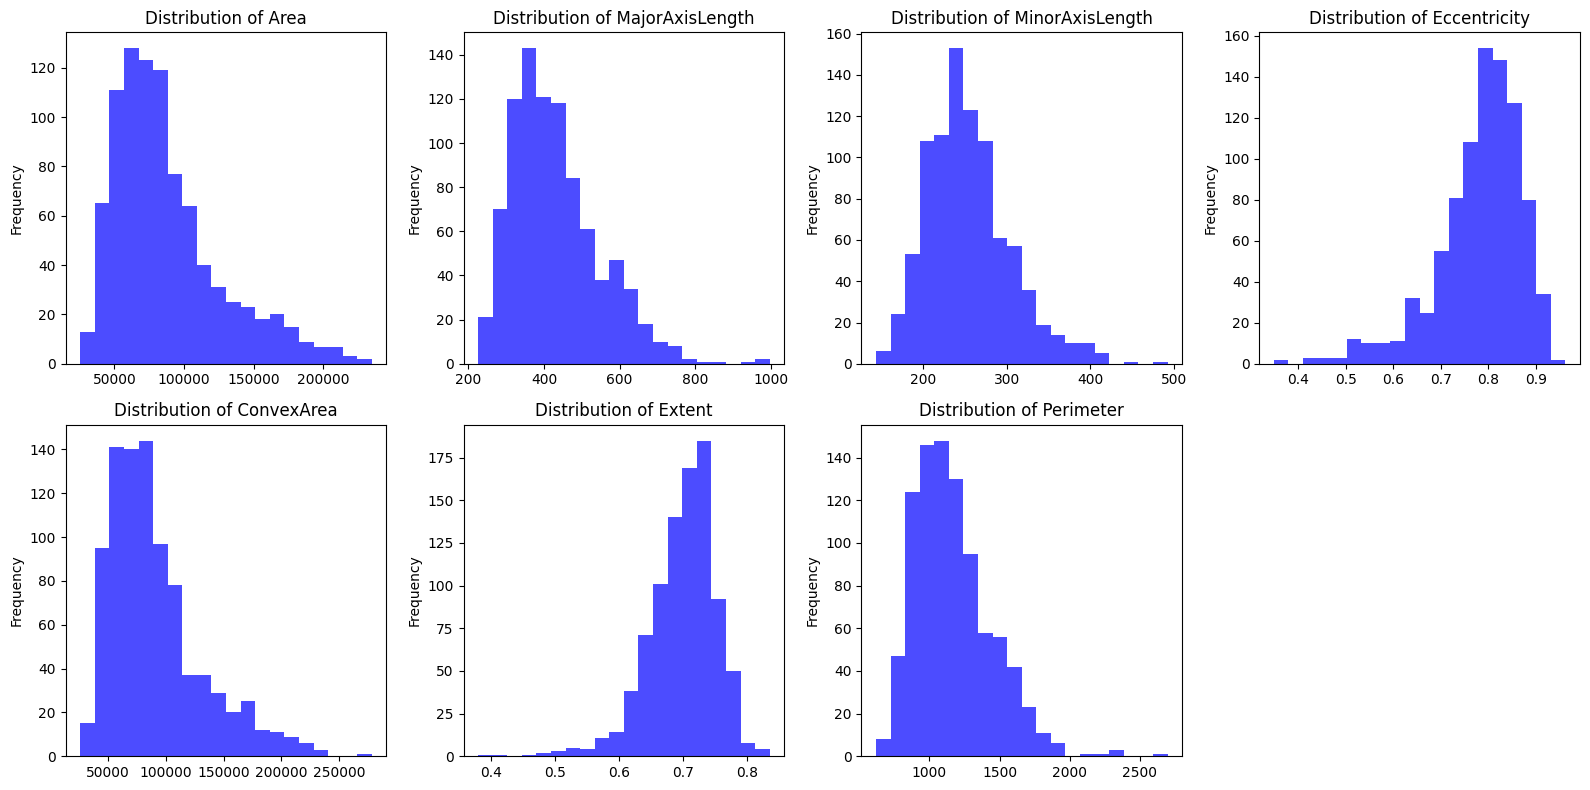

In [2]:
# Plot histograms for each predictor
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):
    axes[i].hist(df[col], bins=20, color='blue', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Frequency')

# Remove the last subplot (unused)
axes[-1].axis('off')

plt.tight_layout()
plt.show()

This seems skewed, but looks somewhat normal.

Some strategies to employ: 

1. move on with rbf(transform? no transform? compare!)
2. do some scaling, then see if poly is suitable.

We will take on with 1 first.

/Users/bunbun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bunbun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bunbun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bunbun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

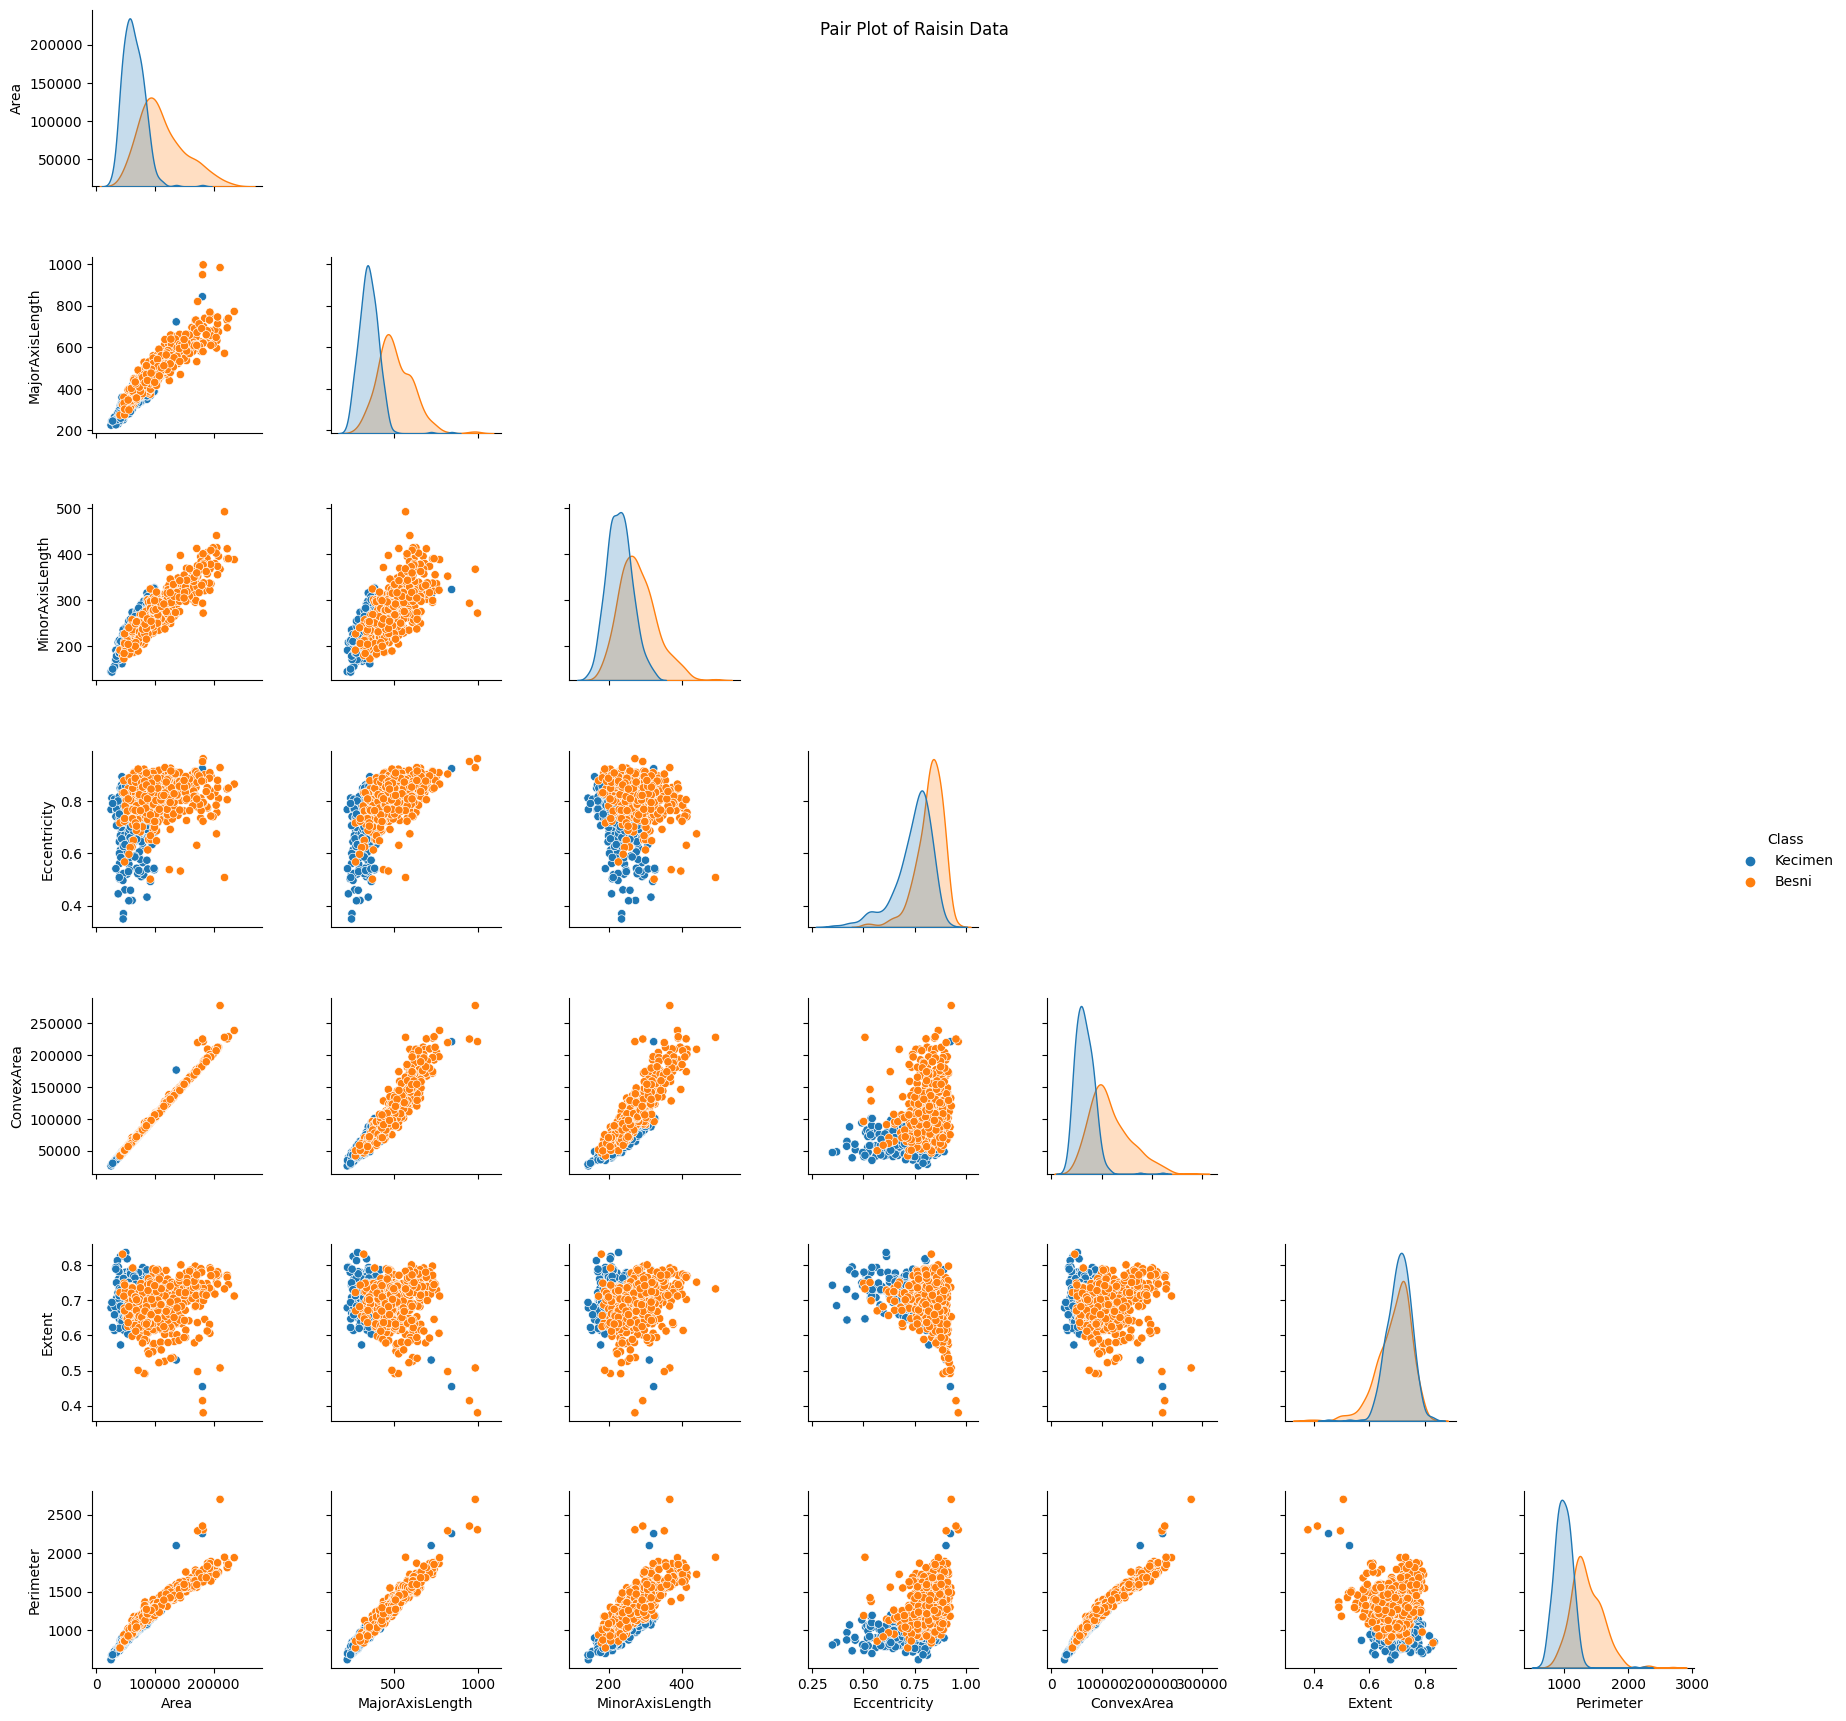

In [3]:
import seaborn as sns
g = sns.pairplot(data=df, diag_kind="kde", hue="Class")

# Set plot title and axis labels
plt.suptitle("Pair Plot of Raisin Data")
plt.xlabel("Variable")
plt.ylabel("Variable")

# Remove upper diagonal subplots
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].remove()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Display the plot
plt.show()

## SVM and its variations
We begin by defining a function for accuracy.

In [4]:
def calculate_accuracy(X, y, w, b):
    # Predict labels
    y_predict = np.sign(np.dot(X, w) + b)
    # Count correctly predicted labels
    correct_predictions = np.sum(y_predict == y)
    # Calculate accuracy
    accuracy = correct_predictions / len(y)
    return accuracy

### Linear SVM
This implementation of SVM calculation assume linear separability.

 We start by minimizing the objective function 1/2*||w||^2 subject to the constraint that the data points are correctly classified, i.e., y_i(w · x_i + b) ≥ 1 for all i. This helps us find the optimal separating hyperplane (the SVM line) with the maximum margin. If the data is linearly separable, this step will yield a solution. We also need to see the performance of the classification.

In [5]:
import numpy as np
import cvxopt

# Step 1: Check if data is linearly separable and find the SVM line
def svm_assuming_LS(X, y):
    n_samples, n_features = X.shape
    # Gram matrix
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = np.dot(X[i], X[j])
    
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
    h = cvxopt.matrix(np.zeros(n_samples))

    # Solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    
    # Intercept
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n], sv])
    b /= len(a)

    # Weights
    w = np.zeros(n_features)
    for n in range(len(a)):
        w += a[n] * sv_y[n] * sv_x[n]
    
    return w, b

w,b = svm_assuming_LS(X_train, y_train)
accuracy_assume_LS = calculate_accuracy(X_test, y_test, w, b)
print(f'Accuracy assuming linear separability using custom svm without scaling: {accuracy_assume_LS:.2f}')
w,b = svm_assuming_LS(X_train_scaled, y_train)
accuracy_assume_LS = calculate_accuracy(X_test_scaled, y_test, w, b)
print(f'Accuracy assuming linear separability using custom svm with scaling: {accuracy_assume_LS:.2f}')

     pcost       dcost       gap    pres   dres
 0: -3.5364e+02 -1.1534e+03  5e+03  6e+01  3e+00
 1: -1.3968e+03 -3.3018e+03  4e+03  4e+01  2e+00
 2: -4.7845e+03 -7.4956e+03  3e+03  3e+01  2e+00
 3: -1.4853e+04 -1.7677e+04  3e+03  2e+01  1e+00
 4: -2.5887e+04 -3.0162e+04  4e+03  2e+01  1e+00
 5: -4.2489e+04 -4.8728e+04  6e+03  2e+01  1e+00
 6: -4.5860e+04 -5.1941e+04  6e+03  2e+01  1e+00
 7: -4.9317e+04 -5.5309e+04  6e+03  2e+01  1e+00
Terminated (singular KKT matrix).
Accuracy assuming linear separability using custom svm without scaling: 0.82
     pcost       dcost       gap    pres   dres
 0: -3.6261e+02 -1.3557e+03  5e+03  5e+01  4e+00
 1: -1.1330e+03 -3.2543e+03  5e+03  4e+01  3e+00
 2: -2.5110e+03 -5.4432e+03  4e+03  3e+01  2e+00
 3: -6.1397e+03 -9.4198e+03  4e+03  2e+01  2e+00
 4: -1.8441e+04 -2.1452e+04  3e+03  2e+01  1e+00
 5: -6.1565e+04 -6.8325e+04  7e+03  2e+01  1e+00
 6: -5.5494e+05 -5.6738e+05  1e+04  1e+01  1e+00
 7: -4.2194e+06 -4.3003e+06  8e+04  1e+01  1e+00
 8: -6.89

Surprisingly, scaled is performing way worse than not scaled. Probably because some errors? or internal problems with lagrangian way of computing?

Strategy: let's try this with gradient descent.

In [6]:

def svm_gradient_descent(X, y, learning_rate=0.01, epochs=1000, lambda_param=0.01):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0

    # Gradient descent
    for epoch in range(epochs):
        for i in range(n_samples):
            if y[i] * (np.dot(X[i], w) + b) < 1:
                w -= learning_rate * (2 * lambda_param * w - np.dot(X[i], y[i]))
                b += learning_rate * y[i]
            else:
                w -= learning_rate * 2 * lambda_param * w

    return w, b


w, b = svm_gradient_descent(X_train, y_train)
accuracy_gradient_descent = calculate_accuracy(X_test, y_test, w, b)
print(f'Accuracy using gradient descent without scaling: {accuracy_gradient_descent:.2f}')
w, b = svm_gradient_descent(X_train_scaled, y_train)
accuracy_gradient_descent = calculate_accuracy(X_test_scaled, y_test, w, b)
print(f'Accuracy using gradient descent with scaling: {accuracy_gradient_descent:.2f}')


Accuracy using gradient descent without scaling: 0.61
Accuracy using gradient descent with scaling: 0.87


Now, we are getting somewhere. It is actually performing better than the black box! Below, we compare with black box linear.

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instantiate and train the black box SVM
black_box_svm = SVC(kernel='linear')
black_box_svm.fit(X_train, y_train)

# Make predictions
black_box_predictions = black_box_svm.predict(X_test)

black_box_accuracy = accuracy_score(y_test, black_box_predictions)


print(f"Black Box SVM Accuracy without scaling: {black_box_accuracy}")

black_box_svm = SVC(kernel='linear')
black_box_svm.fit(X_train_scaled, y_train)

# Make predictions
black_box_predictions = black_box_svm.predict(X_test_scaled)

black_box_accuracy = accuracy_score(y_test, black_box_predictions)
print(f"Black Box SVM Accuracy with scaling: {black_box_accuracy}")


Black Box SVM Accuracy without scaling: 0.85
Black Box SVM Accuracy with scaling: 0.8611111111111112


## SVM with Loss functions
 If the data is not linearly separable, we introduce slack variables ξ_i to allow for misclassifications. We can then experiment with different loss functions to handle these slack variables, such as 0-1 loss, logistic regression (LR) loss, quadratic loss, and hinge loss. Each loss function has its own way of penalizing misclassifications, and we can perform a grid search-like process to find the best parameters (e.g., the regularization parameter) and the best loss function that minimizes the overall loss. for the time being of this assignment, we consider this as a future advancement.
### Hinge loss

In [8]:
def svm_with_hinge_loss(X, y, C=1.0):
    n_samples, n_features = X.shape

    # Compute the kernel matrix (in this case, the linear kernel)
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = np.dot(X[i], X[j])

    # Construct the matrices for the quadratic problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples), 'd')  # Ensure 'A' is a double matrix with correct dimensions
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))

    # Solve the quadratic problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Extract the Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]

    # Calculate the weight vector w
    w = np.zeros(n_features)
    for n in range(len(a)):
        w += a[n] * sv_y[n] * sv_x[n]

    # Calculate the intercept b using support vectors on the margin
    # These are support vectors for which the corresponding alpha is strictly between 0 and C
    margin_sv = (a > 0) & (a < C)
    if any(margin_sv):
        b = np.mean(sv_y[margin_sv] - np.dot(sv_x[margin_sv], w))
    else:
        b = 0

    # Return the weight vector and intercept
    return w, b

# Calculate accuracy using the hinge loss
w, b = svm_with_hinge_loss(X_train, y_train)
predictions = np.sign(np.dot(X_test, w) + b)
accuracy_hinge_loss = np.mean(predictions == y_test)
print(f'Accuracy with hinge loss: {accuracy_hinge_loss:.2f}')

w, b = svm_with_hinge_loss(X_train_scaled, y_train)
predictions = np.sign(np.dot(X_test_scaled, w) + b)
accuracy_hinge_loss = np.mean(predictions == y_test)
print(f'Accuracy with hinge loss with scaled data: {accuracy_hinge_loss:.2f}')

     pcost       dcost       gap    pres   dres
 0: -3.5400e+02 -1.9746e+03  1e+04  3e+00  2e-04
 1: -2.3729e+02 -1.3748e+03  2e+03  4e-01  1e-04
 2: -2.1230e+02 -5.9010e+02  5e+02  9e-02  9e-05
 3: -2.2098e+02 -3.5919e+02  2e+02  2e-02  8e-05
 4: -2.3787e+02 -2.9502e+02  6e+01  7e-03  8e-05
 5: -2.4409e+02 -2.7938e+02  4e+01  4e-03  8e-05
 6: -2.4933e+02 -2.6746e+02  2e+01  2e-03  8e-05
 7: -2.5186e+02 -2.6197e+02  1e+01  8e-04  8e-05
 8: -2.5429e+02 -2.5741e+02  3e+00  2e-04  9e-05
 9: -2.5513e+02 -2.5597e+02  9e-01  2e-05  9e-05
10: -2.5545e+02 -2.5558e+02  1e-01  2e-06  9e-05
11: -2.5549e+02 -2.5553e+02  4e-02  5e-07  9e-05
12: -2.5551e+02 -2.5551e+02  5e-03  6e-08  9e-05
13: -2.5551e+02 -2.5551e+02  7e-05  7e-10  9e-05
14: -2.5551e+02 -2.5551e+02  8e-07  7e-12  1e-04
15: -2.5551e+02 -2.5551e+02  6e-08  2e-14  1e-04
16: -2.5551e+02 -2.5551e+02  4e-09  1e-14  1e-04
17: -2.5551e+02 -2.5551e+02  8e-11  1e-14  1e-04
18: -2.5551e+02 -2.5551e+02  2e-10  7e-15  9e-05
19: -2.5551e+02 -2.55

compare with black box svm.

In [8]:
# svm with hinge loss from black box
from sklearn.svm import LinearSVC
LinearSVC = LinearSVC(C=1.0, loss='hinge')
LinearSVC.fit(X_train, y_train)
predictions = LinearSVC.predict(X_test)
accuracy_hinge_loss = np.mean(predictions == y_test)
print(f'Accuracy with hinge loss from black box: {accuracy_hinge_loss:.2f}')

# Calculate accuracy using the hinge loss with scaled data
LinearSVC.fit(X_train_scaled, y_train)
predictions = LinearSVC.predict(X_test_scaled)
accuracy_hinge_loss = np.mean(predictions == y_test)
print(f'Accuracy with hinge loss from black box with scaled data: {accuracy_hinge_loss:.2f}')


Accuracy with hinge loss from black box: 0.83
Accuracy with hinge loss from black box with scaled data: 0.86


/Users/bunbun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/bunbun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bunbun/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## Quadratic loss functioon

In [9]:
import numpy as np
import cvxopt

# Function to solve the SVM optimization problem with quadratic loss
def svm_with_quadratic_loss(X, y, C=1.0):
    n_samples, n_features = X.shape

    # Constructing the P matrix with the outer product of y and Kernel matrix
    K = np.dot(X, X.T)
    P = cvxopt.matrix(np.outer(y, y) * K)
    
    # Constructing the q vector
    q = cvxopt.matrix(-np.ones(n_samples))
    
    # Constructing the G matrix for inequality constraints
    G_top = -np.eye(n_samples)
    G_bottom = np.eye(n_samples)
    G = cvxopt.matrix(np.vstack((G_top, G_bottom)))
    
    # Constructing the h vector for inequality constraints
    h_top = np.zeros(n_samples)
    h_bottom = np.ones(n_samples) * C
    h = cvxopt.matrix(np.hstack((h_top, h_bottom)))
    
    # Constructing the A matrix for equality constraints
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    
    # Constructing the b vector for equality constraints
    b = cvxopt.matrix(0.0)

    # Solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    # Lagrange multipliers
    lagr_mult = np.ravel(solution['x'])

    # Support vectors have non-zero lagrange multipliers
    sv = lagr_mult > 1e-5
    ind = np.arange(len(lagr_mult))[sv]
    a = lagr_mult[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    
    # Intercept
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n], sv])
    b /= len(a)

    # Weight vector
    w = np.dot(sv_x.T, a * sv_y)
    
    return w, b, sv_x, sv_y

# We'll need to create a sample dataset X and a Class label vector y to test the function.


# Now let's run our SVM solver
w, b, sv_x, sv_y = svm_with_quadratic_loss(X_train, y_train)
accuracy_qua_loss = calculate_accuracy(X_test, y_test, w, b)
print(f'Accuracy with quadratic loss: {accuracy_qua_loss:.2f}')


     pcost       dcost       gap    pres   dres
 0: -3.5401e+02 -1.9746e+03  1e+04  3e+00  2e-04
 1: -2.3729e+02 -1.3748e+03  2e+03  4e-01  1e-04
 2: -2.1230e+02 -5.9007e+02  5e+02  9e-02  8e-05
 3: -2.2098e+02 -3.5920e+02  2e+02  2e-02  7e-05
 4: -2.3787e+02 -2.9502e+02  6e+01  7e-03  8e-05
 5: -2.4409e+02 -2.7939e+02  4e+01  4e-03  8e-05
 6: -2.4933e+02 -2.6747e+02  2e+01  2e-03  8e-05
 7: -2.5186e+02 -2.6198e+02  1e+01  8e-04  8e-05
 8: -2.5429e+02 -2.5741e+02  3e+00  2e-04  9e-05
 9: -2.5512e+02 -2.5598e+02  9e-01  2e-05  9e-05
10: -2.5546e+02 -2.5558e+02  1e-01  2e-06  9e-05
11: -2.5550e+02 -2.5553e+02  3e-02  5e-07  8e-05
12: -2.5551e+02 -2.5551e+02  3e-03  3e-08  9e-05
13: -2.5551e+02 -2.5551e+02  8e-05  3e-10  9e-05
14: -2.5551e+02 -2.5551e+02  1e-06  3e-12  9e-05
15: -2.5551e+02 -2.5551e+02  1e-08  2e-14  1e-04
16: -2.5551e+02 -2.5551e+02  9e-10  6e-16  1e-04
17: -2.5551e+02 -2.5551e+02  3e-11  2e-14  1e-04
18: -2.5551e+02 -2.5551e+02  4e-13  4e-14  9e-05
19: -2.5551e+02 -2.55

In [11]:
from sklearn.svm import SVC
def quadratic_kernel(X1, X2):
    return (np.dot(X1, X2.T) + 1) ** 2
svc_quadratic = SVC(kernel=quadratic_kernel)
svc_quadratic.fit(X_train, y_train)
predictions = svc_quadratic.predict(X_test)
accuracy_qua_loss = np.mean(predictions == y_test)
print(f'Accuracy with quadratic loss from black box: {accuracy_qua_loss:.2f}')

# Calculate accuracy using the hinge loss with scaled data
svc_quadratic.fit(X_train_scaled, y_train)
predictions = svc_quadratic.predict(X_test_scaled)
accuracy_qua_loss = np.mean(predictions == y_test)
print(f'Accuracy with quadratic loss from black box with scaled data: {accuracy_qua_loss:.2f}')

## SVM with RBF Kernel and set gamma,c
To further boost generalization, we use Lagrange multipliers to transform the constrained optimization problem into an unconstrained one, which is easier to solve. For the kernel function, we choose the Radial Basis Function (RBF) kernel to handle non-linearly separable data. For the time being of this assignment, we use a common gamma and c = 1.

In [14]:
from scipy.spatial.distance import cdist

# Define the RBF kernel function
def rbf_kernel(X1, X2, gamma):
    # This will compute the RBF kernel between two sets of data (X1 and X2)
    return np.exp(-gamma * cdist(X1, X2, 'sqeuclidean'))

# Define the SVM function with the RBF kernel
def svm_with_rbf_kernel(X, y, C=1.0, gamma=1.0):
    n_samples, n_features = X.shape

    # Compute the RBF kernel matrix
    K = rbf_kernel(X, X, gamma)
    
    # Construct the matrices for the quadratic problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.vstack((np.diag(-np.ones(n_samples)), np.identity(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    
    # Solve the quadratic problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Extract the Lagrange multipliers
    lagr_mult = np.ravel(solution['x'])

    # Select the support vectors
    sv = lagr_mult > 1e-5
    ind = np.arange(len(lagr_mult))[sv]
    a = lagr_mult[sv]
    sv_x = X[sv]
    sv_y = y[sv]

    # Calculate the intercept b
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n], sv])
    b /= len(a)

    # For the RBF kernel, we don't compute w directly, but we return the parameters necessary to make predictions
    return a, sv_x, sv_y, b


In [22]:
def svm_predict(a, sv_x, sv_y, b, X, gamma):
    # Apply the kernel function to the support vectors and the test instances
    K = rbf_kernel(sv_x, X, gamma)
    # Calculate the decision function
    decision_function = np.dot(K.T, a * sv_y) + b
    # Predict class labels
    predictions = np.sign(decision_function)
    return predictions

def calculate_accuracy(predictions, true_labels):
    # Calculate the accuracy as the proportion of correct predictions
    correct_predictions = np.sum(predictions == true_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

# You would need to specify the value for gamma used in training
gamma = 0.1  # Example value, should be the same as used in training
a, sv_x, sv_y, b = svm_with_rbf_kernel(X_train_scaled, y_train, C=1.0, gamma=gamma)
# Make predictions on the test set
predictions = svm_predict(a, sv_x, sv_y, b, X_test_scaled, gamma)

# Calculate the accuracy
accuracy = calculate_accuracy(predictions, y_test)

print(f"The classification accuracy is: {accuracy * 100:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -2.8662e+02 -1.7148e+03  8e+03  3e+00  6e-15
 1: -1.8956e+02 -1.0624e+03  1e+03  1e-01  4e-15
 2: -1.9871e+02 -3.2869e+02  1e+02  2e-02  3e-15
 3: -2.2336e+02 -2.7079e+02  5e+01  4e-03  4e-15
 4: -2.3051e+02 -2.5618e+02  3e+01  2e-03  3e-15
 5: -2.3359e+02 -2.5051e+02  2e+01  1e-03  3e-15
 6: -2.3706e+02 -2.4354e+02  7e+00  2e-04  4e-15
 7: -2.3827e+02 -2.4150e+02  3e+00  4e-05  4e-15
 8: -2.3930e+02 -2.4006e+02  8e-01  7e-06  4e-15
 9: -2.3958e+02 -2.3969e+02  1e-01  3e-07  4e-15
10: -2.3963e+02 -2.3963e+02  3e-03  1e-09  4e-15
11: -2.3963e+02 -2.3963e+02  4e-05  2e-11  4e-15
Optimal solution found.
The classification accuracy is: 86.67%


In [21]:
# Instantiate and train the black box SVM
black_box_svm = SVC(kernel='rbf', gamma=0.1)
black_box_svm.fit(X_train_scaled, y_train)

# Make predictions
black_box_predictions = black_box_svm.predict(X_test_scaled)

black_box_accuracy = accuracy_score(y_test, black_box_predictions)


print(f"Black Box SVM Accuracy: {black_box_accuracy}")

Black Box SVM Accuracy: 0.8666666666666667
